# Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

2024-12-15 00:38:23.221075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734241103.299228   13398 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734241103.320160   13398 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 00:38:23.496788: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load and Preprocess Dataset

In [ ]:
# Dataset paths
base_dir = "Covid19-dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Image parameters
img_height, img_width = 128, 128  # Resize images
batch_size = 32

# Data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


# Build Autoencoder for Feature Extraction

In [ ]:
# Autoencoder
input_img = layers.Input(shape=(img_height, img_width, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

# Train Autoencoder

In [ ]:
def extract_images(generator):
    images = []
    for _ in range(len(generator)):  # Iterate through all batches
        batch_images, _ = next(generator)  # Get images, ignore labels
        images.append(batch_images)
    return np.vstack(images)

# Training autoencoder
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Extract images for training and validation
X_train = extract_images(train_generator)
X_val = extract_images(val_generator)

print("Training images shape:", X_train.shape)
print("Validation images shape:", X_val.shape)

autoencoder.fit(
    X_train,
    X_train,  # Target = input for reconstruction
    epochs=20,
    validation_data=(X_val, X_val),
    callbacks=[early_stop]
)

Training images shape: (201, 128, 128, 3)
Validation images shape: (50, 128, 128, 3)
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step - loss: 0.0725 - val_loss: 0.0588
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - loss: 0.0513 - val_loss: 0.0249
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - loss: 0.0272 - val_loss: 0.0209
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - loss: 0.0203 - val_loss: 0.0132
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step - loss: 0.0128 - val_loss: 0.0095
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - loss: 0.0106 - val_loss: 0.0085
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - loss: 0.0079 - val_loss: 0.0072
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - loss: 0.0059 - val_lo

# Extract Features from the Encoder

In [ ]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("max_pooling2d_2").output)
encoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

# Generate Encoded Features

In [ ]:
# Number of steps (batches) per generator
train_steps = len(train_generator)
val_steps = len(val_generator)
test_steps = len(test_generator)

# Extract features
train_features = encoder.predict(train_generator, steps=train_steps, verbose=1)
val_features = encoder.predict(val_generator, steps=val_steps, verbose=1)
test_features = encoder.predict(test_generator, steps=test_steps, verbose=1)

print("Train features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)
print("Test features shape:", test_features.shape)

# Labels
train_labels = train_generator.classes
val_labels = val_generator.classes
test_labels = test_generator.classes

# Flatten features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

print("Flattened train features shape:", train_features_flat.shape)
print("Flattened validation features shape:", val_features_flat.shape)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step


/home/mavwdj/.pyenv/versions/ml-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step 
Train features shape: (201, 64, 64, 32)
Validation features shape: (50, 64, 64, 32)
Test features shape: (66, 64, 64, 32)
Flattened train features shape: (201, 131072)
Flattened validation features shape: (50, 131072)


In [ ]:
# print(train_generator.class_indices)
# print(np.bincount(train_labels))

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
[89 56 56]


# Build the CNN Classifier

In [ ]:
cnn_model = models.Sequential([
    layers.Input(shape=train_features_flat.shape[1:]),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 classes: Covid, Pneumonia, Normal
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,777,731 (64.00 MB)

 Trainable params: 16,777,731 (64.00 MB)

 Non-trainable params: 0 (0.00 B)

# Train the CNN Classifier

In [ ]:
cnn_history = cnn_model.fit(
    train_features_flat, train_labels,
    epochs=20,
    validation_data=(val_features_flat, val_labels),
    callbacks=[early_stop]
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.3644 - loss: 1.3903 - val_accuracy: 0.2800 - val_loss: 1.3738
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.2896 - loss: 1.4959 - val_accuracy: 0.3400 - val_loss: 1.1204
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.3950 - loss: 1.1366 - val_accuracy: 0.3200 - val_loss: 1.1957
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.4066 - loss: 1.1188 - val_accuracy: 0.3000 - val_loss: 1.1352
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4966 - loss: 1.0217 - val_accuracy: 0.3400 - val_loss: 1.1226
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.4694 - loss: 1.0152 - val_accuracy: 0.3600 - val_loss: 1.1066
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.5373 - loss: 0.9769 - val_accuracy: 0.4200 - val_loss: 1.1052
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.4649 - loss: 0.9881 - val_accuracy: 0.4400 - val_loss:

# Evaluate Model

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_features_flat, test_labels)
print(f"Test Accuracy: {test_accuracy:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4167 - loss: 1.2284
Test Accuracy: 0.33


# Visualize Results

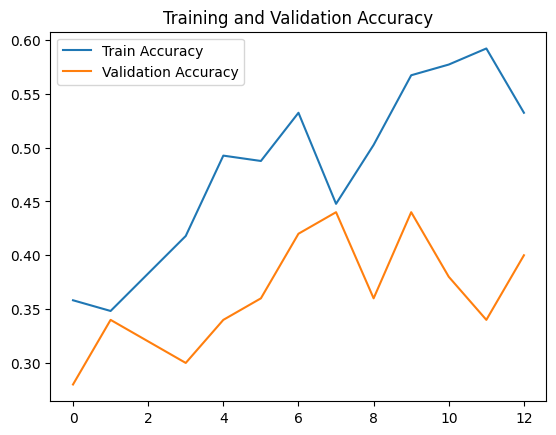

In [ ]:
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()